In [2]:
import inspect
from plonk import PlonkPipeline

# 1. Load (if not already loaded)
if 'pipeline' not in locals():
    pipeline = PlonkPipeline("nicolas-dufour/PLONK_OSV_5M")

# 2. Reveal the EXACT signature of the call function
print("--- FUNCTION SIGNATURE ---")
print(inspect.signature(pipeline.__call__))

# 3. Reveal the documentation (if the author wrote it)
print("\n--- DOCUMENTATION ---")
print(pipeline.__call__.__doc__)

# 4. Check the 'sampler' object 
# It might control the number of steps
if hasattr(pipeline, "sampler"):
    print("\n--- SAMPLER ATTRIBUTES ---")
    print(dir(pipeline.sampler))

c:\Users\Imed\anaconda3\envs\plonk\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


--- FUNCTION SIGNATURE ---
(images, batch_size=None, x_N=None, num_steps=None, scheduler=None, cfg=0, generator=None)

--- DOCUMENTATION ---
Sample from the model given conditioning.

        Args:
            images: Conditioning input (image or list of images)
            batch_size: Number of samples to generate (inferred from cond if not provided)
            x_N: Initial noise tensor (generated if not provided)
            num_steps: Number of sampling steps (uses default if not provided)
            sampler: Custom sampler function (uses default if not provided)
            scheduler: Custom scheduler function (uses default if not provided)
            cfg: Classifier-free guidance scale (default 15)
            generator: Random number generator

        Returns:
            Sampled GPS coordinates after postprocessing
        

--- SAMPLER ATTRIBUTES ---
['__annotations__', '__builtins__', '__call__', '__class__', '__closure__', '__code__', '__defaults__', '__delattr__', '__dic

In [3]:
import torch
import numpy as np
from PIL import Image

# Access the StreetCLIP encoder
# From your other notebook, it's accessed via cond_preprocessing
print("Exploring pipeline structure...")
print(f"Pipeline attributes: {[a for a in dir(pipeline) if not a.startswith('_')]}\n")

# Get the feature extractor (StreetCLIP)
if hasattr(pipeline, 'cond_preprocessing'):
    feature_extractor = pipeline.cond_preprocessing
    print("✅ Found feature extractor via cond_preprocessing")
elif hasattr(pipeline, 'cond_feature_extractor'):
    feature_extractor = pipeline.cond_feature_extractor
    print("✅ Found feature extractor via cond_feature_extractor")
else:
    print("❌ Need to find feature extractor")

# Explore the encoder model structure
print("\nFeature extractor attributes:")
print([a for a in dir(feature_extractor) if not a.startswith('_')])

# Try to access the underlying CLIP model
if hasattr(feature_extractor, 'emb_model'):
    clip_model = feature_extractor.emb_model
    print("\n✅ Found CLIP model via emb_model")
    print(f"CLIP model type: {type(clip_model)}")
    
    # Check if it has vision_model (standard CLIP structure)
    if hasattr(clip_model, 'vision_model'):
        vision_model = clip_model.vision_model
        print("✅ Found vision_model")
        
        # Check for encoder layers
        if hasattr(vision_model, 'encoder'):
            encoder = vision_model.encoder
            print(f"✅ Found encoder with {len(encoder.layers)} layers")
            print(f"First layer type: {type(encoder.layers[0])}")
        else:
            print("Encoder structure:")
            print([a for a in dir(vision_model) if not a.startswith('_')])

Exploring pipeline structure...
Pipeline attributes: ['compute_likelihood', 'compute_likelihood_grid', 'compute_localizability', 'cond_preprocessing', 'device', 'input_dim', 'manifold', 'model', 'model_path', 'network', 'postprocessing', 'preconditioning', 'sampler', 'scheduler', 'to']

✅ Found feature extractor via cond_preprocessing

Feature extractor attributes:
['device', 'emb_model', 'processor']

✅ Found CLIP model via emb_model
CLIP model type: <class 'transformers.models.clip.modeling_clip.CLIPVisionModel'>
✅ Found vision_model
✅ Found encoder with 24 layers
First layer type: <class 'transformers.models.clip.modeling_clip.CLIPEncoderLayer'>


In [4]:
import os
import pandas as pd

# Paths
image_dir = r"C:\Users\Imed\Desktop\VMI\Project\Dev\plonk\datasets\osv5m\images\test\00"
csv_path = r"C:\Users\Imed\.cache\huggingface\hub\datasets--osv5m--osv5m\snapshots\cff33609b56b54d8743b7ee7a416eb8433e9a681\test.csv"

# Load CSV
df_full = pd.read_csv(csv_path)

# Get only the images you actually downloaded
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
downloaded_ids = set([f.replace('.jpg', '') for f in image_files])

print(f"📸 You have {len(downloaded_ids):,} images downloaded")

# Filter dataframe to only downloaded images
df_full['id_str'] = df_full['id'].astype(str)
df = df_full[df_full['id_str'].isin(downloaded_ids)].copy()

print(f"✅ Matched {len(df):,} images with labels")
print(f"\nCountry distribution (top 10):")
print(df['country'].value_counts().head(10))

# Now get a test image
test_row = df.iloc[0]
test_id = test_row['id']
test_country = test_row['country']
test_img_path = os.path.join(image_dir, f"{test_id}.jpg")

print(f"\nTesting with image: {test_id}")
print(f"Country: {test_country}")
print(f"Path exists: {os.path.exists(test_img_path)}")

# Load image
test_img = Image.open(test_img_path).convert('RGB')
print(f"Image size: {test_img.size}")


📸 You have 50,000 images downloaded
✅ Matched 50,000 images with labels

Country distribution (top 10):
country
US    5689
RU    3622
AU    2630
BR    2427
CA    2303
IN    1478
MX    1147
AR    1026
CN    1022
KZ     923
Name: count, dtype: int64

Testing with image: 1006398440000844
Country: IT
Path exists: True
Image size: (1008, 512)


# gradient-based visualization

In [ ]:
print("Using gradient-based visualization (much simpler and faster!)")

# This approach uses gradients to see what the model looks at
# No need to extract attention weights!

from platform import processor
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import zoom

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_saliency_map(img_path, country_name=None):
    """
    Generate saliency map showing what the model looks at
    """
    # Load image
    img = Image.open(img_path).convert('RGB')
    img_display = img.copy()
    
    # Process for model
    inputs = processor(images=img, return_tensors="pt") # type: ignore
    pixel_values = inputs['pixel_values'].to(device).requires_grad_(True)
    
    # Forward pass
    with torch.enable_grad():
        outputs = vision_model(pixel_values=pixel_values)
        # Use the pooled output (CLS token)
        cls_output = outputs.pooler_output
        
        # Get gradient of CLS output with respect to input
        cls_output.sum().backward()
    
    # Get gradients
    grads = pixel_values.grad.data.abs()
    
    # Average over color channels
    saliency = grads.squeeze(0).mean(dim=0).cpu().numpy()
    
    # Normalize
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())
    
    # Resize to original image size
    img_array = np.array(img_display)
    h, w = img_array.shape[:2]
    saliency_resized = zoom(saliency, (h / saliency.shape[0], w / saliency.shape[1]), order=1)
    
    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(img_display)
    axes[0].set_title(f"Original Image\n{country_name if country_name else 'Unknown'}")
    axes[0].axis('off')
    
    axes[1].imshow(saliency_resized, cmap='hot')
    axes[1].set_title("Saliency Map")
    axes[1].axis('off')
    
    axes[2].imshow(img_display)
    axes[2].imshow(saliency_resized, alpha=0.5, cmap='hot')
    axes[2].set_title("Overlay")
    axes[2].axis('off')
    
    plt.tight_layout()
    return fig, saliency_resized

# Test it!
fig, saliency = get_saliency_map(test_img_path, test_country)
plt.savefig('saliency_test.png', dpi=150, bbox_inches='tight')
print(f"✅ Saliency map generated!")
print(f"Saved to: saliency_test.png")

In [19]:
import os
import random

# Create output directory
os.makedirs('attention_results', exist_ok=True)

# Sample diverse images
print("Sampling diverse images...")

# Get images from different countries
diverse_samples = []
for country in ['US', 'RU', 'AU', 'BR', 'FR', 'IN', 'CN', 'AR']:
    country_imgs = df[df['country'] == country].sample(min(3, len(df[df['country'] == country])))
    diverse_samples.extend(country_imgs.to_dict('records'))

print(f"Selected {len(diverse_samples)} diverse images")

# Generate saliency maps
for i, row in enumerate(diverse_samples[:20]):  # Limit to 20 for time
    img_path = os.path.join(image_dir, f"{row['id']}.jpg")
    
    if not os.path.exists(img_path):
        continue
    
    print(f"Processing {i+1}/20: {row['country']}...")
    
    try:
        fig, saliency = get_saliency_map(img_path, row['country'])
        fig.savefig(f"attention_results/{i:02d}_{row['country']}_{row['id']}.png", 
                    dpi=150, bbox_inches='tight')
        plt.close(fig)
    except Exception as e:
        print(f"  Error: {e}")
        continue

print("\n✅ All saliency maps generated!")
print(f"Saved in: attention_results/")

Sampling diverse images...
Selected 24 diverse images
Processing 1/20: US...
Processing 2/20: US...
Processing 3/20: US...
Processing 4/20: RU...
Processing 5/20: RU...
Processing 6/20: RU...
Processing 7/20: AU...
Processing 8/20: AU...
Processing 9/20: AU...
Processing 10/20: BR...
Processing 11/20: BR...
Processing 12/20: BR...
Processing 13/20: FR...
Processing 14/20: FR...
Processing 15/20: FR...
Processing 16/20: IN...
Processing 17/20: IN...
Processing 18/20: IN...
Processing 19/20: CN...
Processing 20/20: CN...

✅ All saliency maps generated!
Saved in: attention_results/


In [ ]:
# Compute statistics across images
print("Computing saliency statistics...")

stats = {
    'country': [],
    'entropy': [],
    'max_saliency': [],
    'concentration': []  # How focused is attention?
}

for row in diverse_samples[:50]:
    img_path = os.path.join(image_dir, f"{row['id']}.jpg")
    
    if not os.path.exists(img_path):
        continue
    
    try:
        _, saliency = get_saliency_map(img_path, row['country'])
        
        # Flatten saliency
        s_flat = saliency.flatten()
        s_flat = s_flat / s_flat.sum()  # Normalize to probability
        
        # Entropy (how spread out is attention?)
        entropy = -(s_flat * np.log(s_flat + 1e-10)).sum()
        
        # Max saliency
        max_sal = saliency.max()
        
        # Concentration (top 10% of pixels get what % of attention?)
        top_10_percent = int(len(s_flat) * 0.1)
        sorted_sal = np.sort(s_flat)[::-1]
        concentration = sorted_sal[:top_10_percent].sum()
        
        stats['country'].append(row['country'])
        stats['entropy'].append(entropy)
        stats['max_saliency'].append(max_sal)
        stats['concentration'].append(concentration)
        
    except:
        continue

# Plot statistics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(stats['entropy'], bins=20, edgecolor='black')
axes[0].set_title('Attention Entropy Distribution')
axes[0].set_xlabel('Entropy (higher = more spread out)')

axes[1].hist(stats['concentration'], bins=20, edgecolor='black', color='orange')
axes[1].set_title('Attention Concentration')
axes[1].set_xlabel('% in top 10% of pixels')

axes[2].scatter(stats['entropy'], stats['concentration'], alpha=0.6)
axes[2].set_xlabel('Entropy')
axes[2].set_ylabel('Concentration')
axes[2].set_title('Entropy vs Concentration')

plt.tight_layout()
plt.savefig('attention_statistics.png', dpi=150)
print("✅ Statistics saved!")

# Attention

In [15]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import pandas as pd
import os

# Load model
from plonk import PlonkPipeline

print("Loading PLONK model...")
pipeline = PlonkPipeline("nicolas-dufour/PLONK_OSV_5M")
feature_extractor = pipeline.cond_preprocessing
clip_model = feature_extractor.emb_model
vision_model = clip_model.vision_model

# CRITICAL: Enable attention extraction
vision_model.config._attn_implementation = 'eager'
vision_model.config.output_attentions = True

# Get processor (CORRECT - it's just .processor, not .image_processor)
processor = feature_extractor.processor

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vision_model = vision_model.to(device)

print(f"✅ Model loaded on {device}")
print(f"✅ Attention implementation: {vision_model.config._attn_implementation}")
print(f"✅ Processor: {type(processor)}")

Loading PLONK model...
✅ Model loaded on cuda
✅ Attention implementation: eager
✅ Processor: <class 'transformers.models.clip.processing_clip.CLIPProcessor'>


In [14]:
# Load CSV
csv_path = r"C:\Users\Imed\.cache\huggingface\hub\datasets--osv5m--osv5m\snapshots\cff33609b56b54d8743b7ee7a416eb8433e9a681\test.csv"
df = pd.read_csv(csv_path)

# Image directory
image_dir = r"C:\Users\Imed\Desktop\VMI\Project\Dev\plonk\datasets\osv5m\images\test\00"

print(f"✅ Loaded {len(df)} images")
print(f"✅ Countries: {df['country'].nunique()}")

# Pick a test image
test_country = 'IT'
test_row = df[df['country'] == test_country].iloc[0]
test_img_path = os.path.join(image_dir, f"{test_row['id']}.jpg")

print(f"Test image: {test_country}, ID: {test_row['id']}")

✅ Loaded 210122 images
✅ Countries: 219
Test image: IT, ID: 1006398440000844


Fixing attention implementation...
✅ Attention implementation: eager
✅ output_attentions: True

Input shape: torch.Size([1, 3, 336, 336])

Output type: <class 'transformers.modeling_outputs.BaseModelOutputWithPooling'>

🎉 SUCCESS! Got 24 attention layers
First attention shape: torch.Size([1, 16, 577, 577])

Layer -1 attention shape: torch.Size([16, 577, 577])
  Num heads: 16
  Sequence length: 577
CLS attention to patches: (576,)
Grid size: 24x24

✅ REAL attention visualization saved!


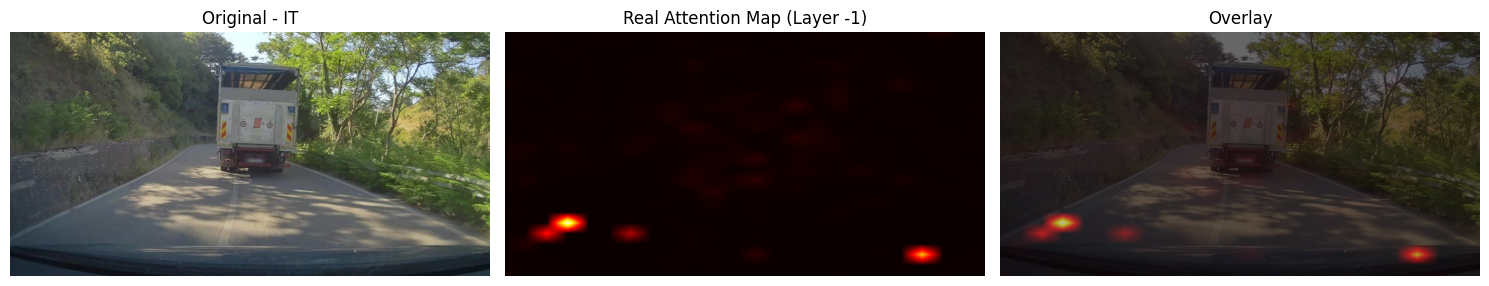

In [16]:
print("Fixing attention implementation...")

# Set attention implementation to 'eager' to enable output_attentions
vision_model.config._attn_implementation = 'eager'
vision_model.config.output_attentions = True

print(f"✅ Attention implementation: {vision_model.config._attn_implementation}")
print(f"✅ output_attentions: {vision_model.config.output_attentions}")

# Process image
test_img = Image.open(test_img_path).convert('RGB')
inputs = processor(images=test_img, return_tensors="pt")
pixel_values = inputs['pixel_values'].to(device)

print(f"\nInput shape: {pixel_values.shape}")

# Forward pass with attention output
with torch.no_grad():
    outputs = vision_model(
        pixel_values=pixel_values,
        output_attentions=True
    )

print(f"\nOutput type: {type(outputs)}")

# Check if we have attentions
if hasattr(outputs, 'attentions') and outputs.attentions is not None and outputs.attentions[0] is not None:
    print(f"\n🎉 SUCCESS! Got {len(outputs.attentions)} attention layers")
    print(f"First attention shape: {outputs.attentions[0].shape}")
    
    # Store attentions for visualization
    attention_weights = outputs.attentions
    
    # Visualize last layer
    layer_idx = -1  # Last layer
    attn = attention_weights[layer_idx][0]  # [num_heads, seq_len, seq_len]
    
    print(f"\nLayer {layer_idx} attention shape: {attn.shape}")
    print(f"  Num heads: {attn.shape[0]}")
    print(f"  Sequence length: {attn.shape[1]}")
    
    # Average over attention heads
    attn_avg = attn.mean(dim=0).cpu().numpy()  # [seq_len, seq_len]
    
    # Get CLS token attention to all patches
    cls_attn = attn_avg[0, 1:]  # Skip CLS token itself
    
    print(f"CLS attention to patches: {cls_attn.shape}")
    
    # Reshape to grid
    grid_size = int(np.sqrt(len(cls_attn)))
    print(f"Grid size: {grid_size}x{grid_size}")
    
    attn_map = cls_attn.reshape(grid_size, grid_size)
    
    # Normalize
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())
    
    # Resize to image size
    img_array = np.array(test_img)
    h, w = img_array.shape[:2]
    attn_resized = zoom(attn_map, (h / grid_size, w / grid_size), order=1)
    
    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(test_img)
    axes[0].set_title(f"Original - {test_country}")
    axes[0].axis('off')
    
    axes[1].imshow(attn_resized, cmap='hot')
    axes[1].set_title(f"Real Attention Map (Layer {layer_idx})")
    axes[1].axis('off')
    
    axes[2].imshow(test_img)
    axes[2].imshow(attn_resized, alpha=0.6, cmap='hot')
    axes[2].set_title("Overlay")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig('attention_real_final.png', dpi=150, bbox_inches='tight')
    print("\n✅ REAL attention visualization saved!")
    
else:
    print("\n❌ Still no attentions!")
    if hasattr(outputs, 'attentions'):
        print(f"outputs.attentions = {outputs.attentions}")

In [22]:
import os
from tqdm import tqdm

os.makedirs('attention_analysis', exist_ok=True)

print("Using matched images...")

# Use df_matched which was already created in your linear probing notebook
# If it doesn't exist, create it
if 'df_matched' not in locals():
    print("Creating df_matched...")
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    downloaded_ids = set([f.replace('.jpg', '') for f in image_files])
    df['id_str'] = df['id'].astype(str)
    df_matched = df[df['id_str'].isin(downloaded_ids)].copy()
    print(f"✅ Matched {len(df_matched):,} images")

# Use ALL matched images (50k)
sampled_data = df_matched.to_dict('records')

print(f"Processing {len(sampled_data):,} images")
print(f"Countries: {df_matched['country'].nunique()}")

# Storage
stats = {
    'image_id': [],
    'country': [],
    'attention_entropy': [],
    'attention_max': [],
    'attention_concentration_top10': [],
    'attention_concentration_top25': [],
    'num_high_attention_patches': [],
    'attention_spread': []
}

attention_maps_storage = []

print("\nExtracting attention...")

for idx, row in enumerate(tqdm(sampled_data, desc="Processing")):
    img_path = os.path.join(image_dir, f"{row['id']}.jpg")
    
    if not os.path.exists(img_path):
        continue
    
    try:
        img = Image.open(img_path).convert('RGB')
        inputs = processor(images=img, return_tensors="pt")
        pixel_values = inputs['pixel_values'].to(device)
        
        with torch.no_grad():
            outputs = vision_model(pixel_values=pixel_values, output_attentions=True)
        
        attn = outputs.attentions[-1][0]
        attn_avg = attn.mean(dim=0).cpu().numpy()
        cls_attn = attn_avg[0, 1:]
        
        cls_attn_norm = cls_attn / (cls_attn.sum() + 1e-8)
        
        entropy = float(-(cls_attn_norm * np.log(cls_attn_norm + 1e-10)).sum())
        max_attn = float(cls_attn.max())
        
        sorted_attn = np.sort(cls_attn_norm)[::-1]
        top_10_percent = int(len(sorted_attn) * 0.1)
        top_25_percent = int(len(sorted_attn) * 0.25)
        concentration_10 = float(sorted_attn[:top_10_percent].sum())
        concentration_25 = float(sorted_attn[:top_25_percent].sum())
        
        high_attn_patches = int((cls_attn > cls_attn.mean()).sum())
        attn_spread = float(cls_attn.std())
        
        stats['image_id'].append(row['id'])
        stats['country'].append(row['country'])
        stats['attention_entropy'].append(entropy)
        stats['attention_max'].append(max_attn)
        stats['attention_concentration_top10'].append(concentration_10)
        stats['attention_concentration_top25'].append(concentration_25)
        stats['num_high_attention_patches'].append(high_attn_patches)
        stats['attention_spread'].append(attn_spread)
        
        if len(attention_maps_storage) < 200:
            grid_size = int(np.sqrt(len(cls_attn)))
            attn_map = cls_attn.reshape(grid_size, grid_size)
            attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min() + 1e-8)
            
            attention_maps_storage.append({
                'id': row['id'],
                'country': row['country'],
                'img': img,
                'attention': attn_map,
                'entropy': entropy,
                'concentration': concentration_10
            })
        
    except Exception as e:
        continue

print(f"\n✅ Processed {len(stats['image_id'])} images!")

stats_df = pd.DataFrame(stats)
stats_df.to_csv('attention_analysis/attention_statistics_50k.csv', index=False)
print(f"✅ Saved!")

print(f"\n📊 Statistics ({len(stats_df):,} images):")
print(f"Mean entropy: {stats_df['attention_entropy'].mean():.3f}")
print(f"Mean concentration: {stats_df['attention_concentration_top10'].mean():.3f}")
print(f"Mean high attention patches: {stats_df['num_high_attention_patches'].mean():.1f}")

Using matched images...
Creating df_matched...
✅ Matched 50,000 images
Processing 50,000 images
Countries: 217

Extracting attention...


Processing: 100%|██████████| 50000/50000 [1:16:06<00:00, 10.95it/s]



✅ Processed 50000 images!
✅ Saved!

📊 Statistics (50,000 images):
Mean entropy: 4.531
Mean concentration: 0.666
Mean high attention patches: 95.2


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load statistics
stats_df = pd.read_csv('attention_analysis/attention_statistics_50k.csv')

print(f"Loaded {len(stats_df)} statistics")

# Create comprehensive plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Entropy distribution
axes[0, 0].hist(stats_df['attention_entropy'], bins=50, color='steelblue', alpha=0.7)
axes[0, 0].axvline(stats_df['attention_entropy'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {stats_df["attention_entropy"].mean():.2f}')
axes[0, 0].set_xlabel('Attention Entropy')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Attention Entropy\n(Lower = More Focused)')
axes[0, 0].legend()

# 2. Concentration in top 10%
axes[0, 1].hist(stats_df['attention_concentration_top10'], bins=50, color='coral', alpha=0.7)
axes[0, 1].axvline(stats_df['attention_concentration_top10'].mean(), color='red', linestyle='--',
                   label=f'Mean: {stats_df["attention_concentration_top10"].mean():.2f}')
axes[0, 1].set_xlabel('Top-10% Concentration')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Attention Concentration in Top 10% Patches\n(Higher = More Focused)')
axes[0, 1].legend()

# 3. Entropy vs Concentration (scatter)
axes[0, 2].scatter(stats_df['attention_entropy'], 
                   stats_df['attention_concentration_top10'],
                   alpha=0.3, s=10, color='green')
axes[0, 2].set_xlabel('Entropy')
axes[0, 2].set_ylabel('Top-10% Concentration')
axes[0, 2].set_title('Entropy vs Concentration\n(Inverse Relationship)')

# 4. Max attention value
axes[1, 0].hist(stats_df['attention_max'], bins=50, color='purple', alpha=0.7)
axes[1, 0].axvline(stats_df['attention_max'].mean(), color='red', linestyle='--',
                   label=f'Mean: {stats_df["attention_max"].mean():.3f}')
axes[1, 0].set_xlabel('Max Attention Value')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Peak Attention')
axes[1, 0].legend()

# 5. Number of high attention patches
axes[1, 1].hist(stats_df['num_high_attention_patches'], bins=50, color='orange', alpha=0.7)
axes[1, 1].axvline(stats_df['num_high_attention_patches'].mean(), color='red', linestyle='--',
                   label=f'Mean: {stats_df["num_high_attention_patches"].mean():.1f}')
axes[1, 1].set_xlabel('Number of High-Attention Patches')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Patches Above Mean Attention')
axes[1, 1].legend()

# 6. Top countries by average concentration
top_countries = stats_df.groupby('country')['attention_concentration_top10'].mean().sort_values(ascending=False).head(15)
axes[1, 2].barh(range(len(top_countries)), top_countries.values, color='teal')
axes[1, 2].set_yticks(range(len(top_countries)))
axes[1, 2].set_yticklabels(top_countries.index)
axes[1, 2].set_xlabel('Mean Concentration')
axes[1, 2].set_title('Top 15 Countries by Attention Focus')
axes[1, 2].invert_yaxis()

plt.tight_layout()
plt.savefig('attention_analysis/comprehensive_statistics.png', dpi=150, bbox_inches='tight')
print("✅ Comprehensive statistics plot saved!")

# Summary statistics
print(f"\n📊 Summary Statistics (50k images):")
print(f"Entropy: {stats_df['attention_entropy'].mean():.3f} ± {stats_df['attention_entropy'].std():.3f}")
print(f"Top-10% Concentration: {stats_df['attention_concentration_top10'].mean():.3f} ± {stats_df['attention_concentration_top10'].std():.3f}")
print(f"High Attention Patches: {stats_df['num_high_attention_patches'].mean():.1f} ± {stats_df['num_high_attention_patches'].std():.1f}")

In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import numpy as np
import random

print("Selecting 20 diverse attention examples...")

# Select diverse images across different metrics
diverse_indices = []

# Get images with different attention patterns
# 5 high concentration (focused)
high_conc = stats_df.nlargest(100, 'attention_concentration_top10').sample(5, random_state=42)
diverse_indices.extend(high_conc.index.tolist())

# 5 low concentration (diffuse)
low_conc = stats_df.nsmallest(100, 'attention_concentration_top10').sample(5, random_state=42)
diverse_indices.extend(low_conc.index.tolist())

# 5 high entropy (spread out)
high_ent = stats_df.nlargest(100, 'attention_entropy').sample(5, random_state=42)
diverse_indices.extend(high_ent.index.tolist())

# 5 medium (typical)
medium = stats_df.iloc[20000:30000].sample(5, random_state=42)
diverse_indices.extend(medium.index.tolist())

print(f"Selected {len(diverse_indices)} diverse examples")

# Load and visualize
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.flatten()

for idx, stat_idx in enumerate(diverse_indices[:20]):
    row = stats_df.iloc[stat_idx]
    img_id = row['image_id']
    country = row['country']
    entropy = row['attention_entropy']
    concentration = row['attention_concentration_top10']
    
    img_path = os.path.join(image_dir, f"{img_id}.jpg")
    
    if not os.path.exists(img_path):
        continue
    
    try:
        # Load image
        img = Image.open(img_path).convert('RGB')
        
        # Get attention
        inputs = processor(images=img, return_tensors="pt")
        pixel_values = inputs['pixel_values'].to(device)
        
        with torch.no_grad():
            outputs = vision_model(pixel_values=pixel_values, output_attentions=True)
        
        attn = outputs.attentions[-1][0]
        attn_avg = attn.mean(dim=0).cpu().numpy()
        cls_attn = attn_avg[0, 1:]
        
        # Reshape
        grid_size = int(np.sqrt(len(cls_attn)))
        attn_map = cls_attn.reshape(grid_size, grid_size)
        attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min() + 1e-8)
        
        # Resize
        img_array = np.array(img)
        h, w = img_array.shape[:2]
        attn_resized = zoom(attn_map, (h / grid_size, w / grid_size), order=1)
        
        # Plot
        axes[idx].imshow(img)
        axes[idx].imshow(attn_resized, alpha=0.5, cmap='hot')
        axes[idx].set_title(f"{country}\nE:{entropy:.2f} C:{concentration:.2f}", 
                           fontsize=9)
        axes[idx].axis('off')
        
    except Exception as e:
        print(f"Error on {img_id}: {e}")
        continue

plt.tight_layout()
plt.savefig('attention_analysis/diverse_20_examples.png', dpi=150, bbox_inches='tight')
print("✅ 20 diverse examples saved!")
plt.show()